In [1]:
%cd ../..
%pwd
import sys, os, json
sys.path.append(os.path.abspath("src"))

from c_cluster_analysis.cat_probe_2.inf_capture_penult import (
    load_model_and_tokenizer, run_probe_batch_from_files
)

input_int = 2001
input_count = str(input_int)
verbnonverb = "unverb"
MODEL = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
model, tok, model_name, _ = load_model_and_tokenizer(MODEL)

data_dir = "data/mmlu"
output_dir = "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B"
cat_probe_dir = output_dir + "/cat_probe"

questions_file = data_dir + "/input_mcq_data.json"
hints_file     = data_dir + "/hints_sycophancy.json" # can be None!
whitelist_file = output_dir + "/filter/"+verbnonverb+"_ids_"+input_count+"_sycophancy.json"

/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/root/CoTFaithChecker


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-03 21:29:16,117 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda
2025-05-03 21:29:17,180 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


In [ ]:
hint_type = "sycophancy"
run_probe_batch_from_files(
    model, tok,
    questions_file=questions_file,
    hints_file=hints_file,
    full_cot_file  = data_dir + "/" + model_name + "/" + hint_type + "/completions_with_" + input_count + ".json",
    whitelist_file=whitelist_file,
    output_file=cat_probe_dir+"/"+hint_type+"_"+verbnonverb+"_"+input_count+".json",
    max_questions=input_int
)

In [3]:
#out_file       = "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/cat_probe/sentence_level_results_sycophancy_unverbalized_ids.json"
hins_file = None
hint_type = "none"
run_probe_batch_from_files(
    model, tok,
    questions_file=questions_file,
    hints_file=hints_file,
    full_cot_file  = data_dir + "/" + model_name + "/" + hint_type + "/completions_with_" + input_count + ".json",
    whitelist_file=whitelist_file,
    output_file=cat_probe_dir+"/"+hint_type+"_"+verbnonverb+"_"+input_count+".json",
    max_questions=input_int
)

print("Done")

2025-05-03 19:39:41,800 - INFO - kept 126 questions after whitelist
questions: 100%|██████████| 126/126 [06:45<00:00,  3.22s/q]
2025-05-03 19:46:44,677 - INFO - saved 126 records to c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/cat_probe/none_unverb_2001.json


Done


In [2]:
import json, gzip, math, random, pathlib, itertools
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

DATA_DIR   = Path("data/mmlu")
MODEL_DIR  = Path("c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/cat_probe")
SYCO_VEC_FILE  = MODEL_DIR / "sycophancy_unverb_2001.json"   # probe vectors w/ hints
PLAIN_VEC_FILE = MODEL_DIR / "none_unverb_2001.json"         # probe vectors w/o hints
#ANN_FILE   = DATA_DIR / "annotations.jsonl"              # 12-category human labels
CAT_FILE       = Path("c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/confidence/sycophancy_unverb_2001.json")

CATEGORY_NAMES = [
    "problem_restating","knowledge_augmentation","assumption_validation",
    "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
    "backtracking","forward_planning","decision_confirmation",
    "answer_reporting","option_restating","other",
]


In [3]:
def load_probe_json(path: Path) -> pd.DataFrame:
    """flatten probe file into one row per sentence"""
    rows = []
    for obj in json.loads(path.read_text()):
        qid = obj["question_id"]
        for s in obj["sentences"]:
            rows.append({
                "question_id": qid,
                "sentence_id": s["sentence_id"],
                "sentence":    s["sentence"],
                "vec":         np.array(s["sent_vec"], dtype=np.float32),
            })
    return pd.DataFrame(rows)

def load_categories(path: Path) -> pd.DataFrame:
    rows = []
    for obj in json.loads(path.read_text()):
        qid = obj["question_id"]
        for ann in obj["annotations"]:
            rec = {"question_id": qid, "sentence_id": ann["sentence_id"]}
            rec.update({c: ann[c] for c in CATEGORY_NAMES})
            rows.append(rec)
    return pd.DataFrame(rows)

probe_syco  = load_probe_json(SYCO_VEC_FILE)
probe_plain = load_probe_json(PLAIN_VEC_FILE)
cats_df     = load_categories(CAT_FILE)

# merge
syco  = probe_syco.merge(cats_df, on=["question_id","sentence_id"])
plain = probe_plain.merge(cats_df, on=["question_id","sentence_id"])

print("rows – sycophancy:", len(syco), "   plain:", len(plain))
syco.head(2)


rows – sycophancy: 1797    plain: 1927


,question_id,sentence_id,sentence,vec,problem_restating,knowledge_augmentation,assumption_validation,logical_deduction,option_elimination,uncertainty_or_certainty_expression,backtracking,forward_planning,decision_confirmation,answer_reporting,option_restating,other
0,68,1,"Okay, so I need to figure out which of the giv...","[-0.13085938, -0.41992188, -0.14257812, 0.0874...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,68,2,Let me start by reading the speech carefully t...,"[0.34960938, -0.23339844, 0.13085938, -0.13867...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
# ════════════════════════════════════════════════════════════════"""
"""X = np.stack(syco["vec"].values)                       # (N, D)
y = syco[CATEGORY_NAMES].values.argmax(1)              # hard label: arg-max category

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# store indices so we can re-use them later
test_idx = X_test.shape[0]                      # length
test_mask = np.zeros(len(syco), dtype=bool)
test_mask[np.random.RandomState(42).choice(len(syco), size=test_idx, replace=False)] = True"""

X_all = np.stack(syco["vec"].values)                       # (N, D)
y_all = syco[CATEGORY_NAMES].values.argmax(1)              # (N,)

idx_all = np.arange(len(syco))
idx_train, idx_test, y_train, y_test = train_test_split(
    idx_all, y_all, test_size=0.2, random_state=42, stratify=y_all)

X_train = X_all[idx_train]
X_test  = X_all[idx_test]

syco_train = syco.iloc[idx_train].reset_index(drop=True)
syco_test  = syco.iloc[idx_test].reset_index(drop=True)


clf = LogisticRegression(max_iter=1_000, multi_class="multinomial")
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print("acc  :", accuracy_score(y_test, pred))
print("macro-F1:", f1_score(y_test, pred, average="macro"))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


acc  : 0.3527777777777778
macro-F1: 0.19799576865609905


acc  : 0.3527777777777778
macro-F1: 0.19799576865609905
                                     precision    recall  f1-score   support

                  problem_restating      0.621     0.545     0.581        33
             knowledge_augmentation      0.373     0.394     0.384        71
              assumption_validation      0.000     0.000     0.000         4
                  logical_deduction      0.434     0.551     0.486       107
                 option_elimination      0.143     0.062     0.087        16
uncertainty_or_certainty_expression      0.189     0.189     0.189        37
                       backtracking      0.000     0.000     0.000         8
                   forward_planning      0.333     0.250     0.286        20
              decision_confirmation      0.000     0.000     0.000         5
                   answer_reporting      0.000     0.000     0.000         2
                   option_restating      0.154     0.146     0.150        41
                   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

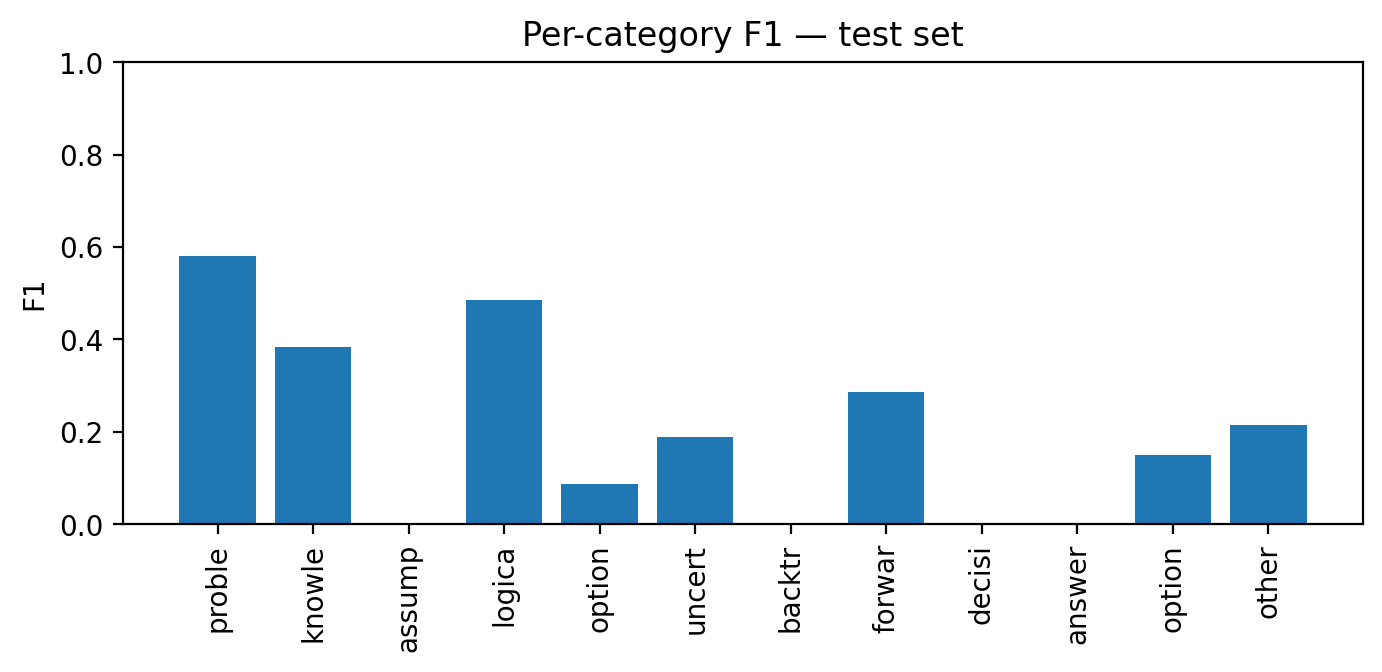

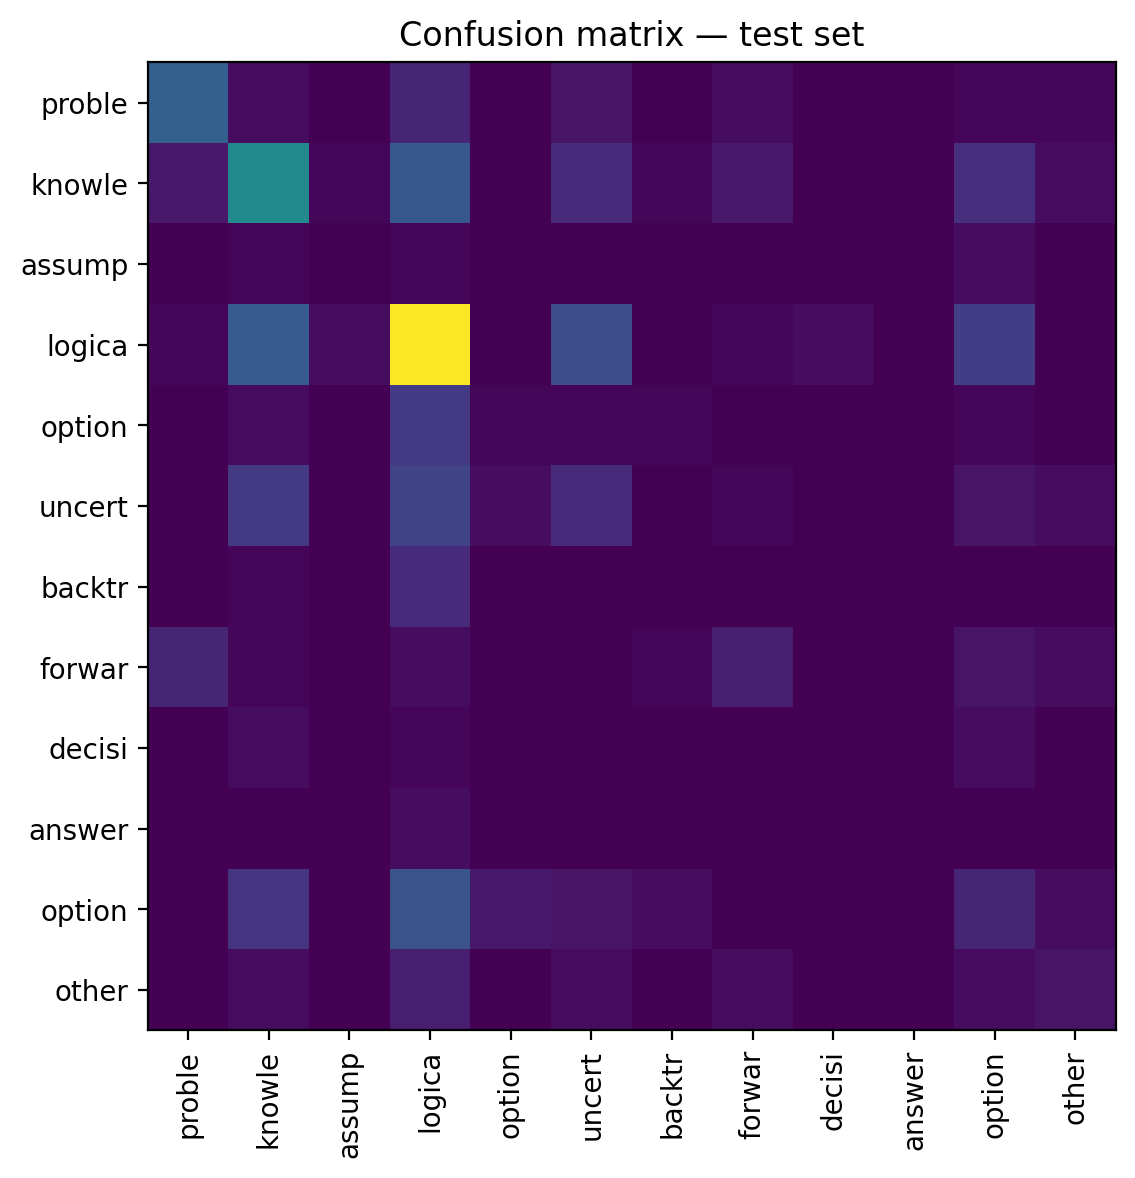

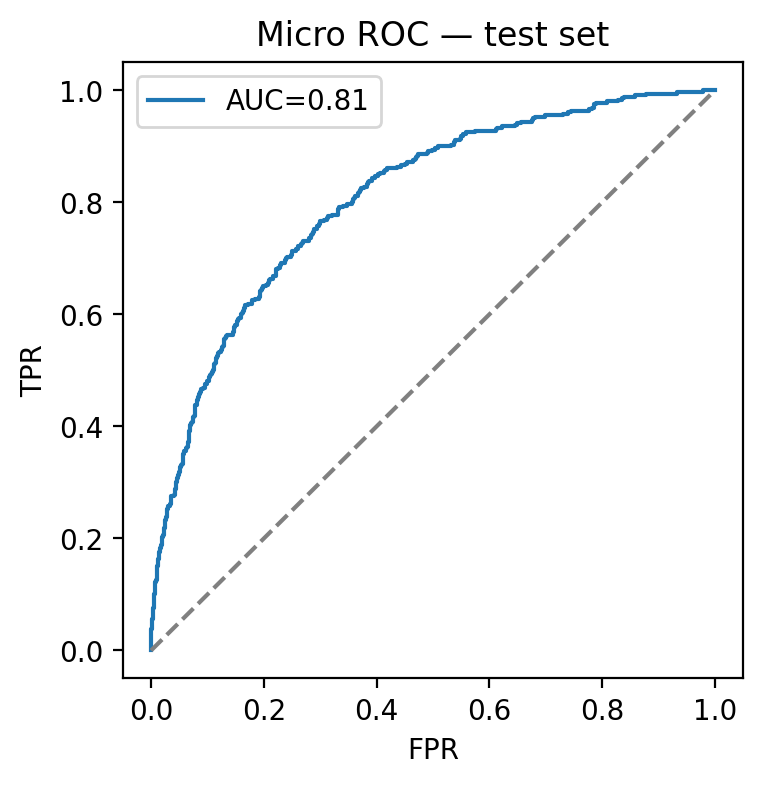

In [5]:
y_prob = clf.predict_proba(X_test)
y_pred = y_prob.argmax(1)
print("acc  :", accuracy_score(y_test, y_pred))
print("macro-F1:", f1_score(y_test, y_pred, average="macro"))

from sklearn.metrics import classification_report, precision_recall_fscore_support
print(classification_report(
      y_test, y_pred, target_names=CATEGORY_NAMES, digits=3))

# per-category F1 bar
_, _, f1s, _ = precision_recall_fscore_support(
    y_test, y_pred, labels=range(len(CATEGORY_NAMES)))
plt.figure(figsize=(8,3))
plt.bar(range(len(CATEGORY_NAMES)), f1s)
plt.xticks(range(len(CATEGORY_NAMES)), [c[:6] for c in CATEGORY_NAMES], rotation=90)
plt.ylabel("F1"); plt.ylim(0,1)
plt.title("Per-category F1 — test set"); plt.show()

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=range(len(CATEGORY_NAMES)))
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion matrix — test set")
plt.xticks(range(len(CATEGORY_NAMES)), [c[:6] for c in CATEGORY_NAMES], rotation=90)
plt.yticks(range(len(CATEGORY_NAMES)), [c[:6] for c in CATEGORY_NAMES])
plt.tight_layout(); plt.show()

# micro-ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(
    np.eye(len(CATEGORY_NAMES))[y_test].ravel(), y_prob.ravel())
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
plt.plot([0,1],[0,1],'--',c='grey'); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("Micro ROC — test set"); plt.legend(); plt.show()


In [ ]:
"""y_true = y_test                        # already from split
y_prob = clf.predict_proba(X_test)
y_pred = y_prob.argmax(1)

print(classification_report(
      y_true, y_pred, target_names=CATEGORY_NAMES, digits=3))

# bar-plot of F1 per category
from sklearn.metrics import precision_recall_fscore_support
_, _, f1s, _ = precision_recall_fscore_support(
    y_true, y_pred, labels=range(len(CATEGORY_NAMES)))

plt.figure(figsize=(8,3))
plt.bar(range(len(CATEGORY_NAMES)), f1s)
plt.xticks(range(len(CATEGORY_NAMES)), [c[:6] for c in CATEGORY_NAMES], rotation=90)
plt.ylabel("F1")
plt.title("Per-category F1 – test set"); plt.ylim(0,1); plt.show()

# ROC micro
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(
    np.eye(len(CATEGORY_NAMES))[y_true].ravel(), y_prob.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f"micro-AUC={roc_auc:.2f}")
plt.plot([0,1],[0,1],'--',c='grey'); plt.legend()
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Micro ROC – test set"); plt.show()"""


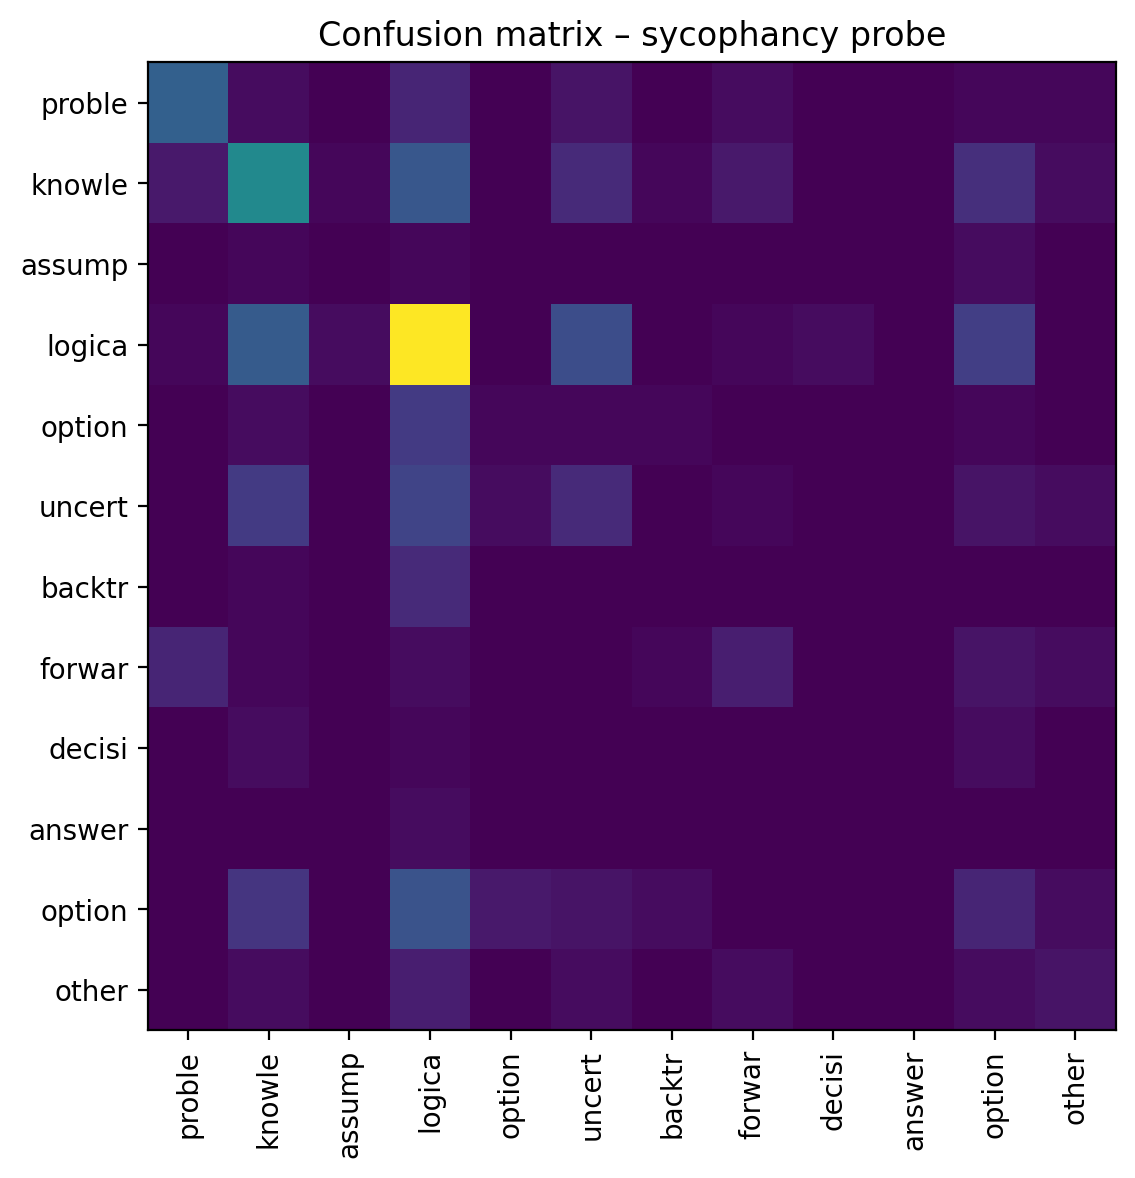

In [ ]:
"""cm = confusion_matrix(y_test, pred, labels=range(len(CATEGORY_NAMES)))

fig = plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion matrix – sycophancy probe")
plt.xticks(range(len(CATEGORY_NAMES)), [c[:6] for c in CATEGORY_NAMES], rotation=90)
plt.yticks(range(len(CATEGORY_NAMES)), [c[:6] for c in CATEGORY_NAMES])
plt.tight_layout()
plt.show()"""


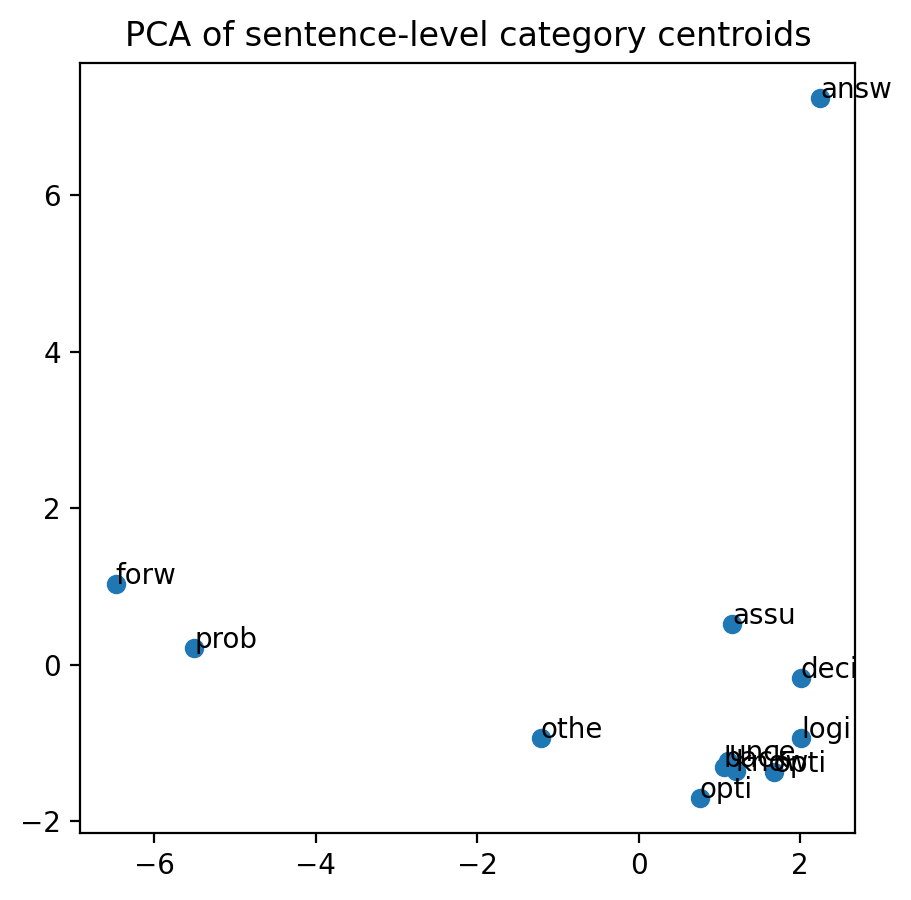

In [6]:
y = syco[CATEGORY_NAMES].values.argmax(1)

centroids = []
for k in range(len(CATEGORY_NAMES)):
    vecs = syco.loc[y == k, "vec"].values          # list/array of (D,) arrays
    if len(vecs) == 0:                             # category not present
        continue
    centroid = np.stack(vecs).mean(0)              # (D,)
    centroids.append(centroid)

centroids = np.stack(centroids)                    # (n_cat_present, D)

pca = PCA(n_components=2).fit(centroids)
pts = pca.transform(centroids)

fig = plt.figure(figsize=(5,5))
plt.scatter(pts[:,0], pts[:,1])
for i,(x,y_) in enumerate(pts):
    plt.text(x, y_, CATEGORY_NAMES[i][:4])
plt.title("PCA of sentence-level category centroids")
plt.show()


In [7]:
# ════════════════════════════════════════════════════════════════
SRC = CATEGORY_NAMES.index("uncertainty_or_certainty_expression")
TGT = CATEGORY_NAMES.index("logical_deduction")

dir_vec = centroids[TGT] - centroids[SRC]
dir_vec /= np.linalg.norm(dir_vec)

def steer(vec, alpha=5.0):
    return vec + alpha * dir_vec

sample_idx = np.where(y_test == SRC)[0][:10]
orig = X_test[sample_idx]
steered = steer(orig)
logits_orig   = clf.predict_proba(orig)
logits_steerd = clf.predict_proba(steered)

print("→ mean p(Logical-Deduction) before :",
      logits_orig[:,TGT].mean())
print("→ mean p(Logical-Deduction) after  :",
      logits_steerd[:,TGT].mean())


→ mean p(Logical-Deduction) before : 0.2054838277562891
→ mean p(Logical-Deduction) after  : 0.8560199084869454


In [8]:
def probe_accuracy(df):
    X = np.stack(df["vec"].values)
    y = df[CATEGORY_NAMES].values.argmax(1)
    return accuracy_score(y, clf.predict(X))

print("probe acc on sycophancy vectors :", probe_accuracy(syco))
print("probe acc on plain vectors      :", probe_accuracy(plain))

# cosine distance between syco & plain versions of *same* sentence
pairs = syco.merge(plain, on=["question_id","sentence_id"], suffixes=("_syco","_plain"))
cos = lambda a,b: 1.0 - np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)+1e-8)
dist = [cos(a,b) for a,b in zip(pairs["vec_syco"], pairs["vec_plain"])]
print("mean cosine distance syco vs. plain:", np.mean(dist))


probe acc on sycophancy vectors : 0.8703394546466333
probe acc on plain vectors      : 0.4120394395433316
mean cosine distance syco vs. plain: 0.2476523288055897


In [11]:
SRC_NAME = "uncertainty_or_certainty_expression"
TGT_NAME = "logical_deduction"
SRC = CATEGORY_NAMES.index(SRC_NAME)
TGT = CATEGORY_NAMES.index(TGT_NAME)
alpha = 5.0

# centroids from TRAIN dat
centroids = {k: np.stack(syco_train.loc[
    syco_train[CATEGORY_NAMES].values.argmax(1)==k, "vec"]).mean(0)
             for k in range(len(CATEGORY_NAMES))}

direction = centroids[TGT] - centroids[SRC]
direction /= np.linalg.norm(direction)

# pick random TEST sentence that probe labels SRC
src_test_rows = np.where(y_pred == SRC)[0]
idx = np.random.choice(src_test_rows)
vec0  = X_test[idx]
text0 = syco_test["sentence"].iloc[idx]

vec1 = vec0 + alpha*direction
prob0 = clf.predict_proba([vec0])[0]
prob1 = clf.predict_proba([vec1])[0]

print("Sentence:", text0)
print("\n==> Probe probs before steering:")
for k in prob0.argsort()[-3:][::-1]:
    print(f"  {CATEGORY_NAMES[k]:36s} {prob0[k]:.3f}")
print("\n==> Probe probs after  steering:")
for k in prob1.argsort()[-3:][::-1]:
    print(f"  {CATEGORY_NAMES[k]:36s} {prob1[k]:.3f}")


Sentence: Option B: The rise of a merchant class in cities who could sponsor the creation of original art.

==> Probe probs before steering:
  uncertainty_or_certainty_expression  0.616
  option_elimination                   0.169
  knowledge_augmentation               0.142

==> Probe probs after  steering:
  logical_deduction                    0.995
  knowledge_augmentation               0.002
  option_elimination                   0.002


                                     precision    recall  f1-score   support

                  problem_restating      0.931     0.908     0.919       163
             knowledge_augmentation      0.869     0.879     0.874       354
              assumption_validation      0.824     0.778     0.800        18
                  logical_deduction      0.863     0.910     0.886       534
                 option_elimination      0.918     0.817     0.865        82
uncertainty_or_certainty_expression      0.838     0.838     0.838       185
                       backtracking      0.872     0.810     0.840        42
                   forward_planning      0.891     0.845     0.868        97
              decision_confirmation      0.905     0.792     0.844        24
                   answer_reporting      1.000     0.800     0.889        10
                   option_restating      0.838     0.830     0.834       206
                              other      0.885     0.841     0.863        8

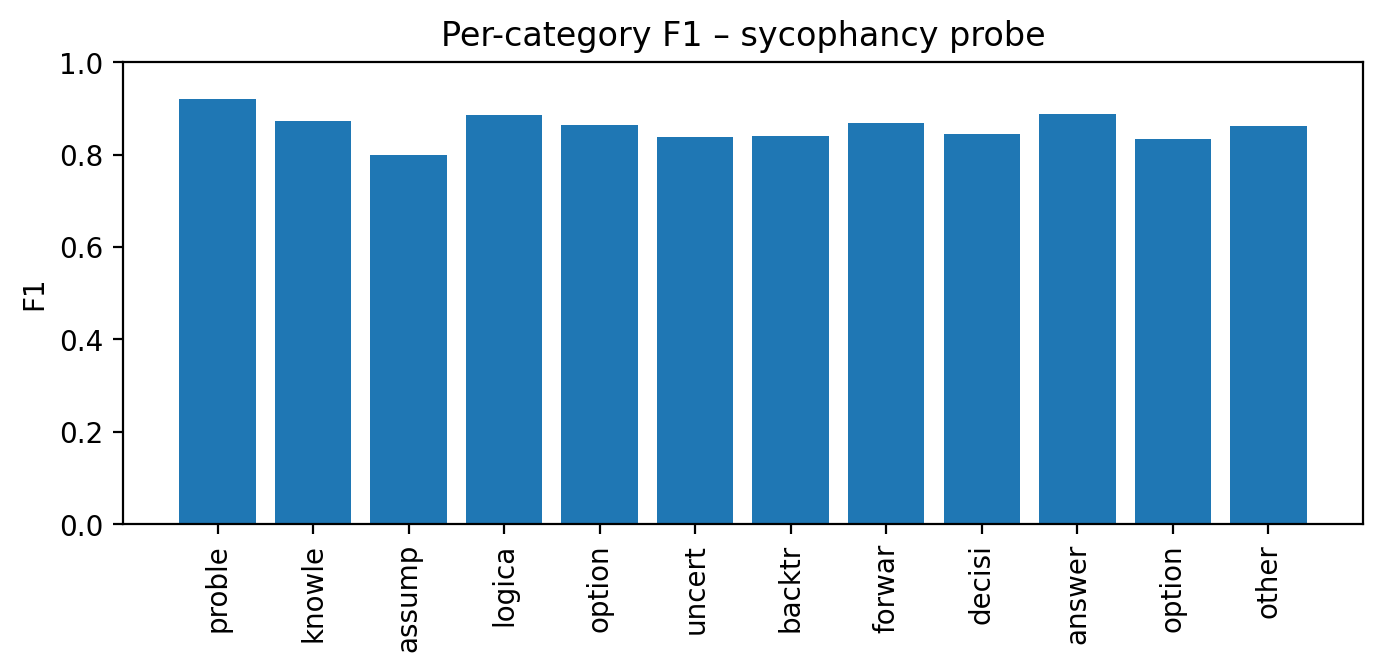

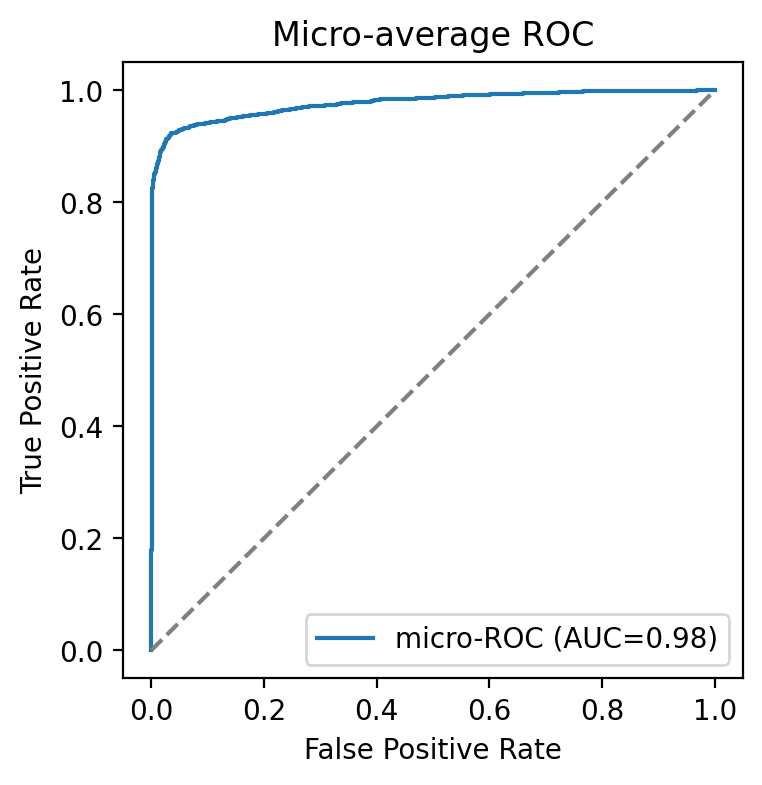

In [18]:
"""# ════════════════════  Probe quality visuals  ════════════════════
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import seaborn as sns

# predictions on the original syco set
y_true = syco[CATEGORY_NAMES].values.argmax(1)
y_prob = clf.predict_proba(np.stack(syco["vec"].values))
y_pred = y_prob.argmax(1)

print(classification_report(y_true, y_pred, target_names=CATEGORY_NAMES, digits=3))

# bar-plot of F1 per category
report = classification_report(
    y_true, y_pred, target_names=CATEGORY_NAMES, output_dict=True)
f1s = [report[c]["f1-score"] for c in CATEGORY_NAMES]

plt.figure(figsize=(8,3))
plt.bar(range(len(CATEGORY_NAMES)), f1s)
plt.xticks(range(len(CATEGORY_NAMES)), [c[:6] for c in CATEGORY_NAMES], rotation=90)
plt.ylabel("F1")
plt.title("Per-category F1 – sycophancy probe")
plt.ylim(0,1); plt.show()

# ROC curves (macro and micro)
fpr = {}; tpr = {}; roc_auc = {}
for i in range(len(CATEGORY_NAMES)):
    fpr[i], tpr[i], _ = roc_curve((y_true==i).astype(int), y_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(
    np.eye(len(CATEGORY_NAMES))[y_true].ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(4,4))
plt.plot(fpr["micro"], tpr["micro"], label=f"micro-ROC (AUC={roc_auc['micro']:.2f})")
plt.plot([0,1],[0,1], ls="--", c="grey")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Micro-average ROC"); plt.legend(); plt.show()"""


In [10]:
SRC_NAME = "uncertainty_or_certainty_expression"
TGT_NAME = "logical_deduction"
SRC = CATEGORY_NAMES.index(SRC_NAME)
TGT = CATEGORY_NAMES.index(TGT_NAME)
alpha = 5.0            # steering strength

centroids = {k: np.stack(syco.loc[
    syco[CATEGORY_NAMES].values.argmax(1)==k, "vec"]).mean(0)
             for k in range(len(CATEGORY_NAMES))}

direction = centroids[TGT] - centroids[SRC]
direction /= np.linalg.norm(direction)

# pick a random sentence from SRC class
idx = np.random.choice(np.where(y_true == SRC)[0])
vec0 = syco["vec"].iloc[idx]
sent_text = syco["sentence"].iloc[idx]

vec1 = vec0 + alpha*direction
prob0 = clf.predict_proba([vec0])[0]
prob1 = clf.predict_proba([vec1])[0]

print("Sentence:", sent_text)
print(f"\n==> Probe probs before steering (top-3):")
for k in prob0.argsort()[-3:][::-1]:
    print(f"  {CATEGORY_NAMES[k]:36s} {prob0[k]:.3f}")
print(f"\n==> Probe probs after  steering (top-3):")
for k in prob1.argsort()[-3:][::-1]:
    print(f"  {CATEGORY_NAMES[k]:36s} {prob1[k]:.3f}")


NameError: name 'y_true' is not defined

In [12]:
# ─── One-off steering demo (test sentence) ──────────────────────
SRC_NAME = "uncertainty_or_certainty_expression"
TGT_NAME = "logical_deduction"
SRC = CATEGORY_NAMES.index(SRC_NAME)
TGT = CATEGORY_NAMES.index(TGT_NAME)
alpha = 5.0

# centroids from TRAIN data (so we don't peek)
centroids = {k: np.stack(syco_train.loc[
    syco_train[CATEGORY_NAMES].values.argmax(1)==k, "vec"]).mean(0)
             for k in range(len(CATEGORY_NAMES))}

direction = centroids[TGT] - centroids[SRC]
direction /= np.linalg.norm(direction)

# pick random TEST sentence that probe labels SRC
src_test_rows = np.where(y_pred == SRC)[0]
idx = np.random.choice(src_test_rows)
vec0  = X_test[idx]
text0 = syco_test["sentence"].iloc[idx]

vec1 = vec0 + alpha*direction
prob0 = clf.predict_proba([vec0])[0]
prob1 = clf.predict_proba([vec1])[0]

print("Sentence:", text0)
print("\n==> Probe probs before steering:")
for k in prob0.argsort()[-3:][::-1]:
    print(f"  {CATEGORY_NAMES[k]:36s} {prob0[k]:.3f}")
print("\n==> Probe probs after  steering:")
for k in prob1.argsort()[-3:][::-1]:
    print(f"  {CATEGORY_NAMES[k]:36s} {prob1[k]:.3f}")


Sentence: But I'm not sure if just telling the cook is enough.

==> Probe probs before steering:
  uncertainty_or_certainty_expression  0.300
  logical_deduction                    0.258
  option_restating                     0.230

==> Probe probs after  steering:
  logical_deduction                    1.000
  option_restating                     0.000
  other                                0.000


In [24]:
"""# ════════════════════  One-off steering demo  ════════════════════
SRC_NAME = "uncertainty_or_certainty_expression"
TGT_NAME = "logical_deduction"
SRC = CATEGORY_NAMES.index(SRC_NAME)
TGT = CATEGORY_NAMES.index(TGT_NAME)
alpha = 5.0            # steering strength

# compute category centroids once (penultimate-layer vectors)
centroids = {k: np.stack(syco.loc[
    syco[CATEGORY_NAMES].values.argmax(1)==k, "vec"]).mean(0)
             for k in range(len(CATEGORY_NAMES))}

direction = centroids[TGT] - centroids[SRC]
direction /= np.linalg.norm(direction)

# pick a random sentence from SRC class
idx = np.random.choice(np.where(y_true == SRC)[0])
vec0 = syco["vec"].iloc[idx]
sent_text = syco["sentence"].iloc[idx]

vec1 = vec0 + alpha*direction
prob0 = clf.predict_proba([vec0])[0]
prob1 = clf.predict_proba([vec1])[0]

print("Sentence:", sent_text)
print(f"\n==> Probe probs before steering (top-3):")
for k in prob0.argsort()[-3:][::-1]:
    print(f"  {CATEGORY_NAMES[k]:36s} {prob0[k]:.3f}")
print(f"\n==> Probe probs after  steering (top-3):")
for k in prob1.argsort()[-3:][::-1]:
    print(f"  {CATEGORY_NAMES[k]:36s} {prob1[k]:.3f}")"""


Sentence: However, the question is about the direction of foreign policy, not the style, so I'm not sure if this is the best fit.

==> Probe probs before steering (top-3):
  uncertainty_or_certainty_expression  0.958
  logical_deduction                    0.029
  option_restating                     0.008

==> Probe probs after  steering (top-3):
  logical_deduction                    1.000
  option_restating                     0.000
  other                                0.000


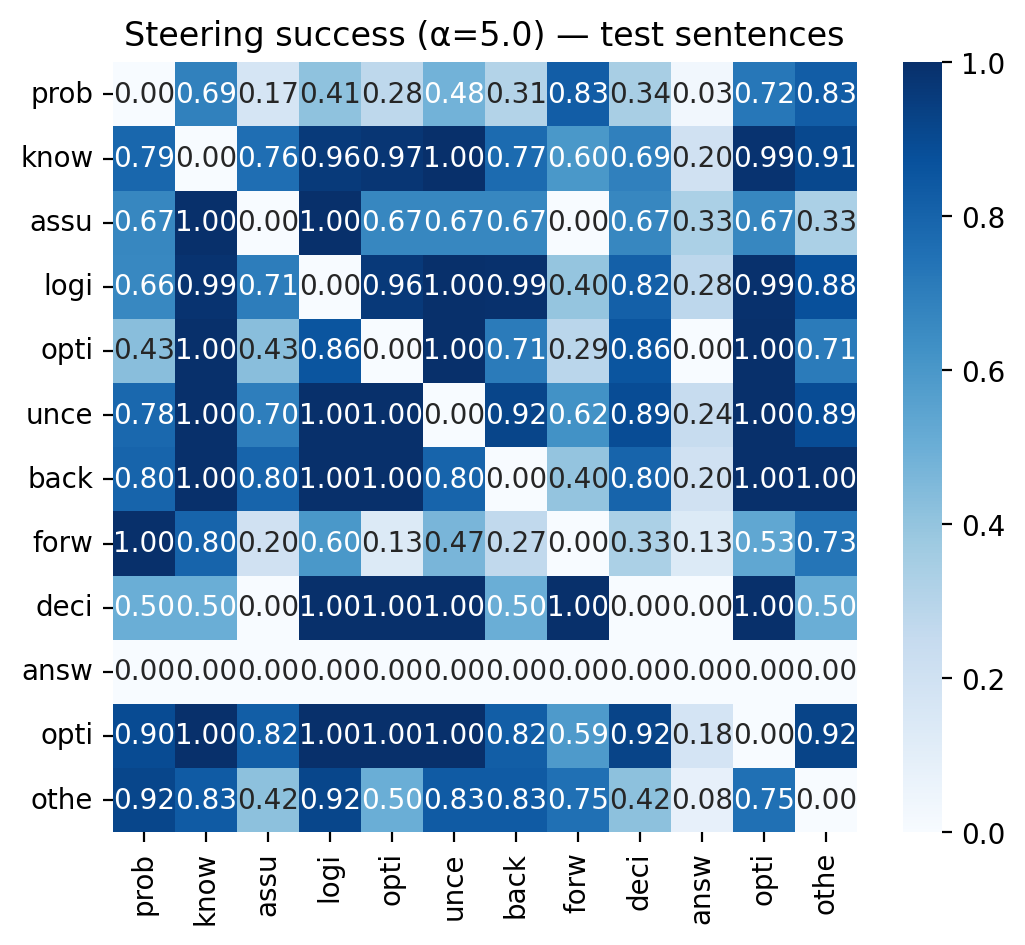

In [13]:
# ─── Steering success heat-map (test set) ───────────────────────
alpha = 5.0
centroids = {k: np.stack(syco_train.loc[
    syco_train[CATEGORY_NAMES].values.argmax(1)==k, "vec"]).mean(0)
             for k in range(len(CATEGORY_NAMES))}

heat = np.zeros((len(CATEGORY_NAMES), len(CATEGORY_NAMES)))

for i in range(len(CATEGORY_NAMES)):
    for j in range(len(CATEGORY_NAMES)):
        if i == j: continue
        direction = centroids[j] - centroids[i]
        direction /= np.linalg.norm(direction)
        idx_rows = np.where(y_pred == i)[0]        # test rows labelled i
        if len(idx_rows)==0: continue
        steered = X_test[idx_rows] + alpha*direction
        new_pred = clf.predict(steered)
        heat[i,j] = (new_pred == j).mean()

heat = np.clip(heat, 0, 1)
plt.figure(figsize=(6,5))
import seaborn as sns
sns.heatmap(heat, annot=True, fmt=".2f",
            xticklabels=[c[:4] for c in CATEGORY_NAMES],
            yticklabels=[c[:4] for c in CATEGORY_NAMES],
            cmap="Blues")
plt.title(f"Steering success (α={alpha}) — test sentences")
plt.show()


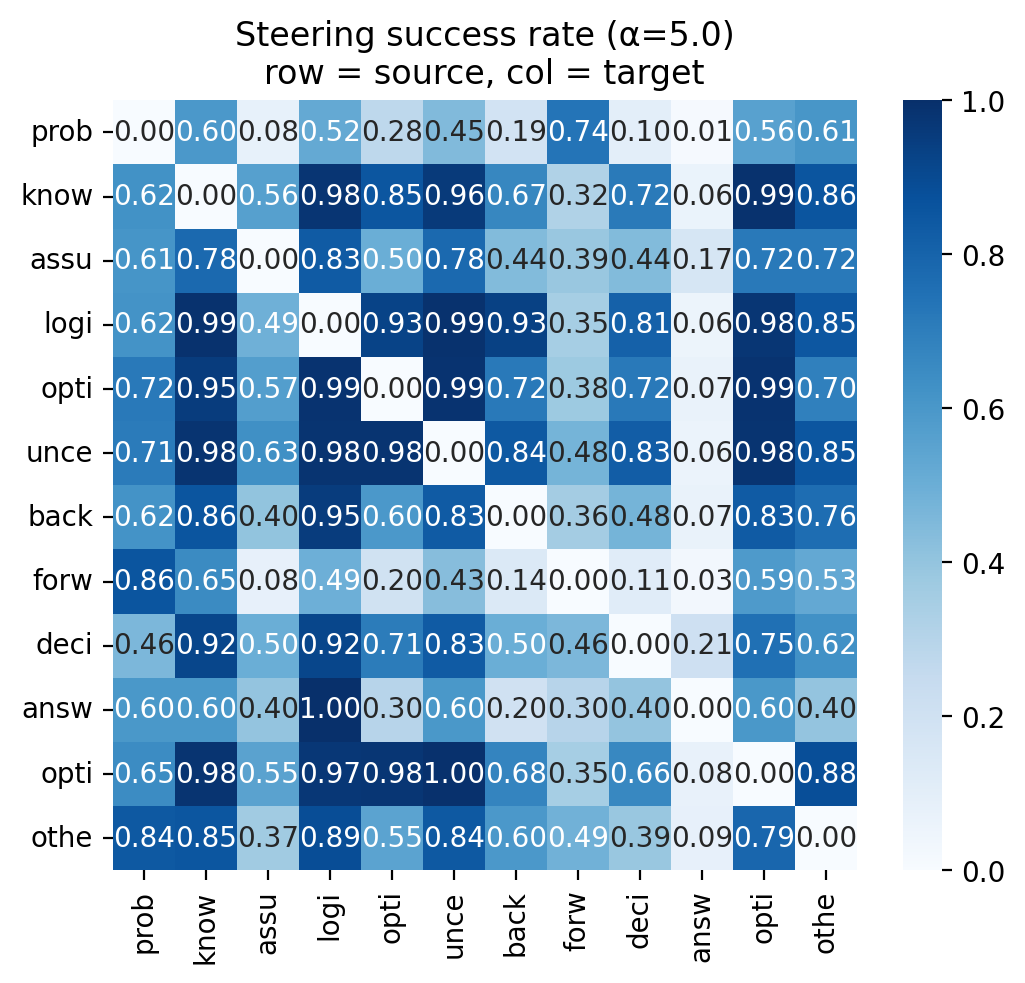

In [22]:
"""# ════════════════════  Steering score-card  ════════════════════
alpha = 5.0
centroids = {k: np.stack(syco.loc[
    y_true==k, "vec"]).mean(0) for k in range(len(CATEGORY_NAMES))}

# baseline predictions
baseline_pred = y_pred.copy()

heat = np.zeros((len(CATEGORY_NAMES), len(CATEGORY_NAMES)))  # from, to

for i in range(len(CATEGORY_NAMES)):
    for j in range(len(CATEGORY_NAMES)):
        if i == j: continue
        direction = centroids[j] - centroids[i]
        direction /= np.linalg.norm(direction)
        steered_vecs = np.stack(syco.loc[y_true==i, "vec"].apply(
            lambda v: v + alpha*direction))
        if len(steered_vecs)==0: continue
        new_pred = clf.predict(steered_vecs)
        heat[i,j] = (new_pred == j).mean()  # fraction flipped to target

plt.figure(figsize=(6,5))
sns.heatmap(heat, annot=True, fmt=".2f",
            xticklabels=[c[:4] for c in CATEGORY_NAMES],
            yticklabels=[c[:4] for c in CATEGORY_NAMES],
            cmap="Blues")
plt.title(f"Steering success rate (α={alpha})\nrow = source, col = target")
plt.show()"""
